# Simulation of an Exothermic CSTR

## Description

This example is intended as an introduction to the nonlinear dynamics of an exothermic continuous stirred-tank reactor. The example has been studied by countless researchers and students since the pioneering work of Amundson and Aris in the 1950's. The particular formulation and parameter values described below are taken from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD).

![Exothermic Reactor](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Agitated_vessel.svg/500px-Agitated_vessel.svg.png)

(Diagram By [Daniele Pugliesi](https://commons.wikimedia.org/wiki/User:Daniele_Pugliesi) own work, [Creative Commons Attribution-Share Alike 3.0 (CC BY-SA 3.0)](http://creativecommons.org/licenses/by-sa/3.0), [Link](https://commons.wikimedia.org/w/index.php?curid=6915706))

## Imports

The following code cell imports the libraries and functions needed within this notebook. The code installs Pyomo if necessary. This code is required to run this notebook in Google Colab.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# if missing, install pyomo and ipopt
import shutil

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))
    
# import pyomo modules
from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator

## Arrehenius Law Kinetics for a First-Order Reaction

We assume the kinetics are dominated by a single first order reaction

$$A \xrightarrow{kc_A}{} \text{Products}$$

The reaction rate per unit volume is modeled as the product $kc_A$ where $c_A$ is the concentration of $A$. The rate constant $k(T)$ is a increases with temperature following the Arrehenius law

$$k(t) = k_0 e^{-\frac{E_a}{RT}}$$

$E_a$ is the activation energy, $R$ is the gas constant, $T$ is absolute temperature, and $k_0$ is the pre-exponential factor. 

We can see the strong temperature dependence by plotting $k(T)$ versus temperature over typical operating conditions.

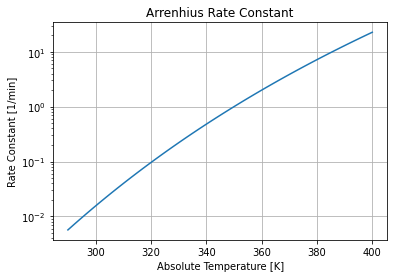

In [2]:
Ea = 72750     # activation energy J/gmol
R = 8.314     # gas constant J/gmol/K
k0 = 7.2e10    # Arrhenius rate constant 1/min

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

T = np.linspace(290, 400)
plt.semilogy(T, k(T))
plt.xlabel('Absolute Temperature [K]')
plt.ylabel('Rate Constant [1/min]')
plt.title('Arrenhius Rate Constant')
plt.grid();

This graph shows the reaction rate changes by three orders of magnitude over the range of possible operating temperatures. Because an exothermic reaction releases heat faster at higher temperatures, there is a positive feedback that can potentially result in unstable process behavior.

## Modeling and Parameter Values

### Mathematical Model

The model consists of mole and energy balances on the contents of the well-mixed reactor.

\begin{align*}
V\frac{dc_A}{dt} & = q(c_{Ai}-c_A)-Vkc_A \\
V\rho C_p\frac{dT}{dt} & = wC_p(T_i-T) + (-\Delta H_R)Vkc_A + UA(T_c-T)
\end{align*}

which are the equations that will be integrated below.

| Quantity | Symbol | Value | Units | Comments |
| :------- | :----: | :---: | :---- | |
| Activation Energy | $E_a$ | 72,750 | J/gmol | |
| Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
| Gas Constant | $R$ | 8.314 | J/gmol/K | |
| Reactor Volume | $V$ | 100 | liters | |
| Density | $\rho$ | 1000 | g/liter | |
| Heat Capacity | $C_p$ | 0.239 | J/g/K | |
| Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
| Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
| Feed flowrate | $q$ | 100 | liters/min | |
| Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
| Feed temperature | $T_f$ | 350 | K | |
| Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
| Initial temperature | $T_0$ | 350 | K | |
| Coolant temperature | $T_c$ | 300 | K | Primary Manipulated Variable |

### Pyomo Model

In [3]:
# reaction and physical properities parameters
Ea = 72750      # activation energy J/gmol
R = 8.314       # gas constant J/gmol/K
k0 = 7.2e10     # Arrhenius rate constant 1/min
dHr = -5.0e4    # enthalpy of reaction [J/mol]
rho = 1000.0    # density [g/L]
Cp = 0.239      # heat capacity [J/g/K]
UA = 5.0e4      # heat transfer [J/min/K]

# reactor operating parameters
V = 100.0       # volume [L]
q = 100.0       # flowrate [L/min]
cAi = 1.0       # inlet feed concentration [mol/L]
Ti = 350.0      # inlet feed temperature [K]
Tc = 300.0      # coolant temperature [K]

# simulation parameters
cA0 = 0.5       # initial concentration [mol/L]
T0 = 350.0      # initial temperature [K]
t_initial = 0.0 # initial time
t_final = 10.0  # final time

def cstr(cA0=cA0, T0=T0):
    """Return a pyomo model with specified initial conditions."""
    
    # create a model instance
    model = ConcreteModel()
    
    # define independent variable
    model.t = ContinuousSet(bounds=(t_initial, t_final))
    
    # define dependent variables
    model.cA = Var(model.t)
    model.T = Var(model.t)
    
    # define derivatives of the dependent variables
    model.dcA = DerivativeVar(model.cA)
    model.dT = DerivativeVar(model.T)

    # set initial conditions
    model.cA[0.0] = cA0
    model.T[0.0] = T0
    
    # define constraints using model equations
    def k(T):
        return k0*exp(-Ea/R/T)
    model.ode1 = Constraint(model.t, rule=lambda model, t: 
        V*model.dcA[t] == q*(cAi - model.cA[t]) - V*k(model.T[t])*model.cA[t])
    model.ode2 = Constraint(model.t, rule=lambda model, t: 
        V*rho*Cp*model.dT[t] == q*rho*Cp*(Ti - model.T[t]) + (-dHr)*V*k(model.T[t])*model.cA[t] + UA*(Tc - model.T[t]))

    return model

## Simulation and Visualization

### Simulation

In [10]:
tsim, ysim = Simulator(cstr(), package='scipy').simulate(numpoints=100)

### Visualization Functions

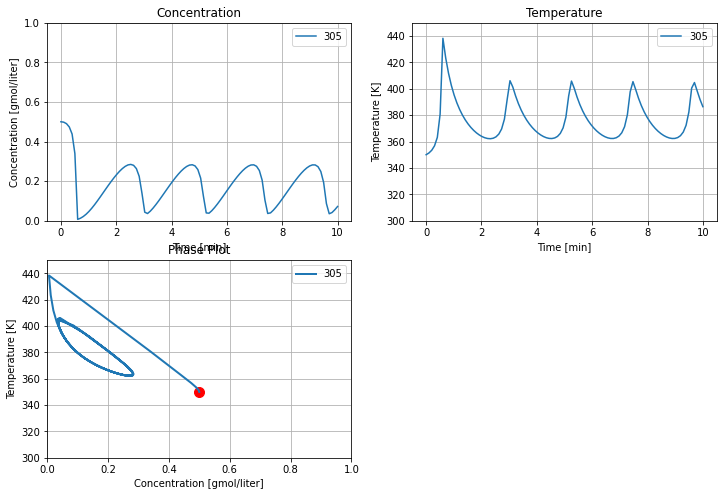

In [11]:
def create_cstr_plot_axes():
    fig = plt.figure(figsize=(12,8))
    ax = [plt.subplot(2, 2, k) for k in range(1, 4)]
 
    ax[0].set_xlabel('Time [min]')
    ax[0].set_ylabel('Concentration [gmol/liter]')
    ax[0].set_title('Concentration')
    ax[0].set_ylim(0, 1)
    ax[0].grid(True)
        
    ax[1].set_xlabel('Time [min]')
    ax[1].set_ylabel('Temperature [K]');
    ax[1].set_title('Temperature')
    ax[1].set_ylim(300, 450)
    ax[1].grid(True)
        
    ax[2].set_xlabel("Concentration [gmol/liter]")
    ax[2].set_ylabel("Temperature [K]");
    ax[2].set_title("Phase Plot")
    ax[2].set_xlim(0, 1)
    ax[2].set_ylim(300, 450)
    ax[2].grid(True)
    
    return ax

def cstr_plot(t, y, ax):
    """Plot cstr simulation results. Create new axes if needed."""
    ax[0].plot(t, y[:, 0], label=str(Tc))
    ax[1].plot(t, y[:, 1], label=str(Tc))
    ax[2].plot(y[0, 0], y[0, 1], 'r.', ms=20)
    ax[2].plot(y[:, 0], y[:, 1], lw=2, label=str(Tc))
    for a in ax:
        a.legend()

ax = create_cstr_plot_axes()
cstr_plot(tsim, ysim, ax);

## Effect of Cooling Temperature

The primary means of controlling the reactoris through temperature of the cooling water jacket. The next calculations explore the effect of plus or minus change of 5 K in cooling water temperature on reactor behavior. These simulations reproduce the behavior shown in Example 2.5 SEMD.

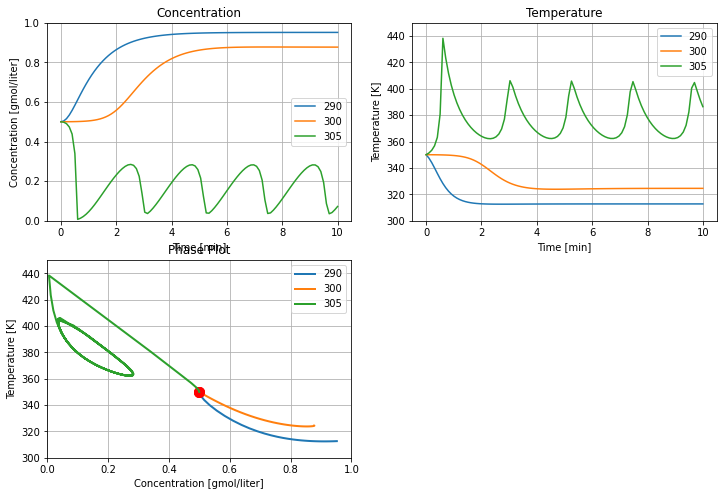

In [12]:
ax = create_cstr_plot_axes()
for Tc in [290, 300, 305]:
    tsim, ysim = Simulator(cstr(), package='scipy').simulate(numpoints=100)
    cstr_plot(tsim, ysim, ax)